In [22]:
pip install opencv-contrib-python

Note: you may need to restart the kernel to use updated packages.


In [23]:
# importing the required header files
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import random

In [24]:
# training part
countOfWords = 0
numberOfSample = 40
input_dir = './Traditional_Chinese_Data/cleaned_data/'  # original location
output_dir = './Output_Sample/'  # location of the trained samples

# global augmentation counter (limit total augmentations to avoid runaway)
countNumber = 0
numberOfAugmentations = 200

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for foloderOfWord in os.listdir(input_dir):
    pathOfWord = os.path.join(input_dir, foloderOfWord)

    if not os.path.exists(pathOfWord):
        continue

    countOfWords += 1
    samplecount = 0
    word_output_dir = os.path.join(output_dir, foloderOfWord)
    os.makedirs(word_output_dir, exist_ok=True)
    
    imgAfterPreprocess = []
    charactersOfChinese = set()

    for sample in os.listdir(pathOfWord):
        if samplecount >= numberOfSample:
            break
        pathOfImage = os.path.join(pathOfWord, sample)

        try:
            img = cv2.imread(pathOfImage)

            if img is None:
                with open(pathOfImage, 'rb') as f:
                    arrayOfImage = np.frombuffer(f.read(), np.uint8)
                    img = cv2.imdecode(arrayOfImage, cv2.IMREAD_COLOR)
                if img is None:
                    print(f"Warning: when decoding is finished, image {pathOfImage} could not be read.")
                    continue

            # convert to grayscale and resize
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if img.ndim == 3 else img
            resized = cv2.resize(gray, (128, 128))
            
            filename_without_ext = os.path.splitext(sample)[0]
            characterOfChinese = None
            for char in filename_without_ext:
                if '\u4e00' <= char <= '\u9fff':
                    characterOfChinese = char
                    charactersOfChinese.add(char)
                    break
            
            if characterOfChinese is None:
                characterOfChinese = filename_without_ext.split('_')[0]
                charactersOfChinese.add(characterOfChinese)

            filenameOfOutput = os.path.splitext(sample)[0] + '.png'
            pathOfOutput = os.path.join(word_output_dir, filenameOfOutput)
            plt.imsave(pathOfOutput, resized, cmap='gray')
            
            imgAfterPreprocess.append(resized)
            samplecount += 1

        except Exception as e:
            print(f"Error processing image {pathOfImage}: {e}")
            continue

    if len(imgAfterPreprocess) > 0:
        numberOfCharacters = len(charactersOfChinese)
        if numberOfCharacters == 0:
            print("This folder does not contain any Chinese characters")
        else:
            numberOfEveryAugmentedImage = 200 // numberOfCharacters
            remainingNumberOfAugmentedImage = 200 % numberOfCharacters
            countOfAugmentation = 0
            
            for indexOfCharacter, characterOfChinese in enumerate(charactersOfChinese):
                target_count = numberOfEveryAugmentedImage + (1 if indexOfCharacter < remainingNumberOfAugmentedImage else 0)
                
                for i, imgBeforeAugmentation in enumerate(imgAfterPreprocess):
                    for j in range(numberOfEveryAugmentedImage):
                        if countOfAugmentation >= target_count:
                            break
                        try:
                            augmentation = random.choice(['translation', 'rotation1', 'rotation2', 'scaling', 'shearing'])
                            h, w = imgBeforeAugmentation.shape[:2]

                            if augmentation == 'translation':
                                Tx = h / 4.0
                                Ty = w / 4.0
                                T = np.array([[1, 0, Tx], [0, 1, Ty]], dtype=np.float32)
                                augmentedImage = cv2.warpAffine(imgBeforeAugmentation, T, (w, h), flags=cv2.INTER_LINEAR,
                                                       borderMode=cv2.BORDER_REPLICATE)
                            
                            elif augmentation == 'rotation1':
                                angle = 45
                                basePoint = (w / 2.0, h / 2.0)
                                rotation_matrix = cv2.getRotationMatrix2D(basePoint, angle, 1.0)
                                augmentedImage = cv2.warpAffine(imgBeforeAugmentation, rotation_matrix, (w, h),
                                                       flags=cv2.INTER_LINEAR,
                                                       borderMode=cv2.BORDER_REPLICATE)
                            elif augmentation == 'rotation2':
                                angle = -80
                                basePoint = (w / 2.0, h / 2.0)
                                rotation_matrix = cv2.getRotationMatrix2D(basePoint, angle, 1.0)
                                augmentedImage = cv2.warpAffine(imgBeforeAugmentation, rotation_matrix, (w, h),
                                                       flags=cv2.INTER_LINEAR,
                                                       borderMode=cv2.BORDER_REPLICATE)
                            elif augmentation == 'scaling':
                                augmentedImage = cv2.resize(imgBeforeAugmentation, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_LINEAR)
                            else:  # shearing / perspective-like transform
                                M = np.array([[1.0, 0.5, 0.0], [0.5, 1.0, 0.0], [0.0, 0.0, 1.0]], dtype=np.float32)
                                augmentedImage = cv2.warpPerspective(imgBeforeAugmentation, M, (int(w * 1.5), int(h * 1.5)),
                                                           flags=cv2.INTER_LINEAR,
                                                           borderMode=cv2.BORDER_REPLICATE)

                            # save augmented image
                            filenameOfAugmentedImg = f"{characterOfChinese}_aug_{countOfAugmentation + 1:03d}.png"
                            augmentedPathOfOutput = os.path.join(word_output_dir, filenameOfAugmentedImg)
                            plt.imsave(augmentedPathOfOutput, augmentedImage, cmap='gray')
                            countOfAugmentation += 1
                        
                        except Exception as e:
                            print(f"Error augmenting image: {e}")
                            continue

    print(f'Processed word: {foloderOfWord}, {countOfAugmentation} augmented images have been generated')

print(f'Total words processed: {countOfWords}')
print(f'Total existing samples processed: {countOfWords * numberOfSample}')
print(f'Total augmented samples processed: {countOfWords * 200}')
        

Processed word: 1, 200 augmented images have been generated
Processed word: 10, 200 augmented images have been generated
Processed word: 100, 200 augmented images have been generated
Processed word: 1000, 200 augmented images have been generated
Processed word: 10000, 200 augmented images have been generated
Processed word: 10001, 200 augmented images have been generated
Processed word: 10002, 200 augmented images have been generated
Processed word: 10003, 200 augmented images have been generated
Processed word: 10004, 200 augmented images have been generated
Processed word: 10005, 200 augmented images have been generated
Processed word: 10006, 200 augmented images have been generated
Processed word: 10007, 200 augmented images have been generated
Processed word: 10008, 200 augmented images have been generated
Processed word: 10009, 200 augmented images have been generated
Processed word: 1001, 200 augmented images have been generated
Processed word: 10010, 200 augmented images have be

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 315ms/step - accuracy: 0.6667 - loss: 8.1538 - val_accuracy: 1.0000 - val_loss: 3.3999
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 295ms/step - accuracy: 1.0000 - loss: 0.7128 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 257ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 271ms/step - accuracy: 1.0000 - lo

d:\DIT5411-Wong Po Yi\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 124, 124, 30)   │           780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 62, 62, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 60, 60, 15)     │         4,065 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 30, 30, 15)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 30, 15)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 13500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     1,728,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 50)             │         6,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 13065)          │       666,315 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,405,738 (9.18 MB)

 Trainable params: 2,405,738 (9.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.8333 - loss: 8.0517 - val_accuracy: 1.0000 - val_loss: 3.2529 - learning_rate: 0.0010
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 1.0000 - loss: 0.6527 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5: early stopping
Model is evaluating...
Test accuracy: 1.


Data loading is finished.


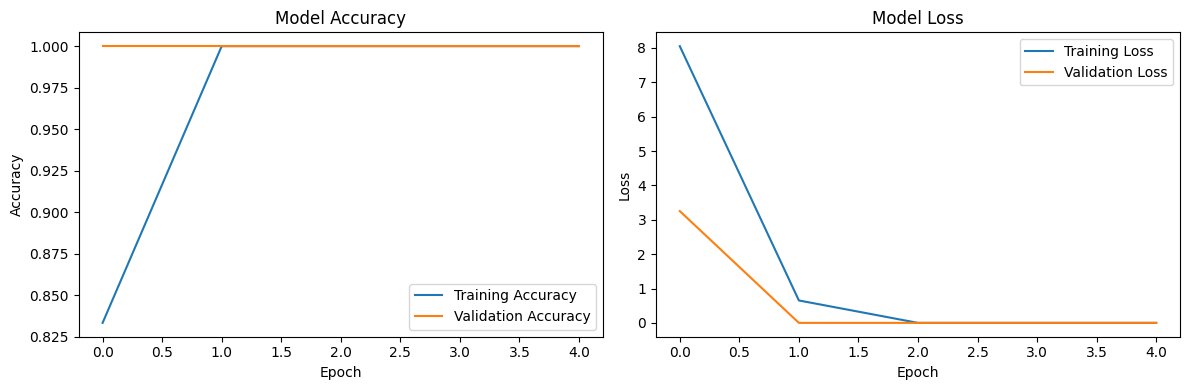

Training completed successfully!


In [9]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import os
import cv2
import numpy as np

# testing part
def load_data(pathOfData, img_size=(128, 128)):
    images = []
    labels = []
    namesOfClass = []
    
    if not os.path.exists(pathOfData):
        print(f"Warning: Data path {pathOfData} does not exist")
        return np.array(images), np.array(labels), namesOfClass
    
    classes = sorted([d for d in os.listdir(pathOfData) 
                    if os.path.isdir(os.path.join(pathOfData, d))])
        
    for nameOfClass in classes:
        class_dir = os.path.join(pathOfData, nameOfClass)
        namesOfClass.append(nameOfClass)
            
        if not os.path.isdir(class_dir):
            continue
        for nameOfImg in os.listdir(class_dir):
            img_path = os.path.join(class_dir, nameOfImg)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, img_size)
                images.append(img)
                labels.append(nameOfClass)
                
    return np.array(images), np.array(labels), namesOfClass

# Use output directory from previous cell for testing
pathOfData = './Output_Sample/'
images, labels, namesOfClass = load_data(pathOfData)

# Check if data was loaded
if len(images) == 0:
    print("Error: No images loaded. Please check the data path.")
else:
    numberOfClasses = len(namesOfClass)
    label_to_index = {name: index for index, name in enumerate(namesOfClass)}
    indexed_labels = np.array([label_to_index[label] for label in labels])
    images = images.reshape(images.shape[0], 128, 128, 1).astype('float32') 
    images = images / 255.0
    indexed_labels = to_categorical(indexed_labels, num_classes=numberOfClasses)
    X_train, X_test, y_train, y_test = train_test_split(images, indexed_labels, test_size=0.2, random_state=42)
    
    def larger_model(numberOfClasses):
        # create model
        model = Sequential()
        model.add(Conv2D(30, (5, 5), input_shape=(128, 128, 1), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(15, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dense(50, activation='relu'))
        model.add(Dense(numberOfClasses, activation='softmax'))
        # Compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model
    
    # build the model
    model = larger_model(numberOfClasses)
    # Fit the model
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)
    # Final evaluation of the model
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Large CNN Error: %.2f%%" % (100-scores[1]*100))
    

# Plot of images as baseline for comparison 
from keras.datasets import mnist 
from matplotlib import pyplot as plt

def prepare_test_set(input_dir, test_output_dir):
    
    input_dir = './Traditional_Chinese_Data/cleaned_data/'  # original location
    test_output_dir = './Testing_Sample/'  # location of the testing samples
    
    # load data 
    (X_train, y_train), (X_test, y_test) = mnist.load_data() 
    
    if not os.path.exists(test_output_dir):
        os.makedirs(test_output_dir)
        classes = sorted([d for d in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, d))])
        
        imagesOfTesting = []
        labelsOfTesting = []
        
    for nameOfClass in classes:
        pathOfClass = os.path.join(input_dir, nameOfClass)
        test_class_path = os.path.join(test_output_dir, nameOfClass)
        
        if not os.path.exists(test_class_path):
            os.makedirs(test_class_path)
        
        for i in range(41, 51):
            nameOfImg = f"字_{i}.png"
            src_path = os.path.join(pathOfClass, nameOfImg)
            dst_path = os.path.join(test_class_path, nameOfImg)
            
            if os.path.exists(src_path):
                import shutil
                shutil.copy2(src_path, dst_path)

                img = cv2.imread(src_path)
                if img is not None:
                    img = cv2.resize(img, (64, 64))
                    img = img.astype('float32') / 255.0
                    imagesOfTesting.append(img)
                    labelsOfTesting.append(nameOfClass)
                    
                    plt.subplot(330 + 1 + i) 
                    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
                    # show the plot
                    plt.show()
    
    print(f"{len(imagesOfTesting)} test images has been prepared.")
    return np.array(imagesOfTesting), labelsOfTesting

def main():
    input_dir = './Output_Sample/'  # use preprocessed data
    test_output_dir = './Testing_Sample/'  # location of the testing samples
    
    os.makedirs(test_output_dir, exist_ok=True)
    
    
    print("Data is handling and loading...")
    X, y, namesOfClass = load_data(input_dir)
    print("Data loading is finished.")
    
    print(f"Size of the dataset: {X.shape}")
    print(f"Quanitity of classes: {len(namesOfClass)}")
    
    X = X.reshape(X.shape[0], 128, 128, 1).astype('float32')
    X = X / 255.0
    y_categorical = to_categorical(y, num_classes=len(namesOfClass))
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_categorical, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Size of the training set: {X_train.shape}")
    print(f"Size of the testing set: {X_test.shape}")
    
    input_shape = (128, 128, 1)
    numberOfClasses = len(namesOfClass)
    
    print(f"Input shape: {input_shape}, input the number of classes: {numberOfClasses}")
    
    model = larger_model(numberOfClasses)
    model.summary()
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)
    ]
    
    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=10,
        validation_data=(X_test, y_test),
        verbose=1,
        callbacks=callbacks
    )
    
    print("Model is evaluating...")
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test accuracy: {test_acc:.4f}")
    
    model.save('trained_model.h5')
    print("Data loading is finished.")
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()
    
    print("Training completed successfully!")

if __name__ == "__main__":
    main()

    
